**IMPORTING LIBRARIES**

In [43]:
import os 
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.models import load_model

In [44]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

**LOADING DATA**

(128, 128, 3)


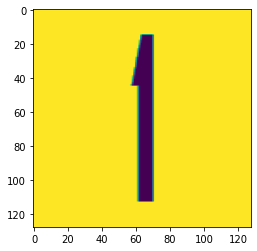

In [45]:
data_dir = 'Data'
img = cv2.imread(os.path.join(data_dir,'1','img002-00001.png'))
# print(img.shape)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
plt.show()

**CREATING DATASET**

In [46]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,color_mode='grayscale',image_size=(32,32),label_mode='categorical')
# label_mode = 'Categorical'.....will perform One-Hot encoding

Found 10160 files belonging to 10 classes.


In [47]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0][0].shape

(32, 32, 1)

In [65]:
batch[1].shape

(16, 10)

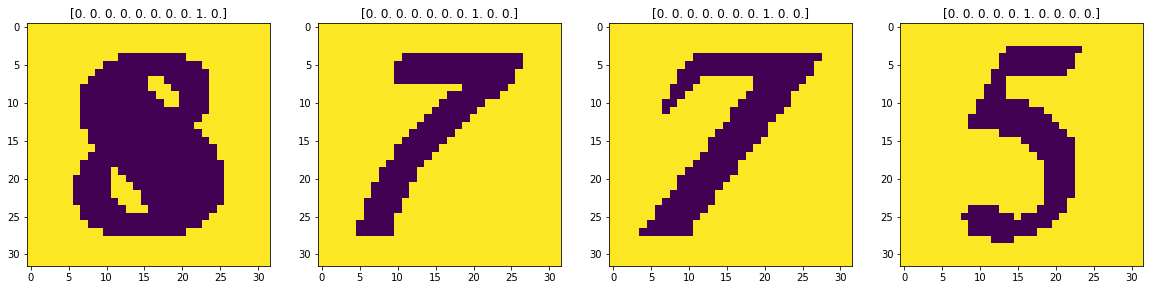

In [61]:
fig,ax = plt.subplots(ncols=4,figsize= (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**NORMALIZING THE DATA**

In [50]:
data = data.map(lambda x,y:(x/255,y))

**SPLITING DATASET**

In [51]:
train_size = int(len(data)*0.7)
val_size  =int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


**BUILDING MODEL**

In [52]:
model = Sequential(
[
    # first set of CONV => RELU => Pool layers
    Conv2D(32,(5,5),padding = 'same',input_shape = (32,32,1),activation='relu'),
    MaxPooling2D(pool_size = (2,2)),

    # second set of CONV => RELU => POOL layers
    Conv2D(32,(3,3),padding = 'same',activation='relu'),
    MaxPooling2D(pool_size = (2,2)),

    # first set of FC => RELU layers
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),

    # second set of FC => RELU layers
    Dense(64,activation='relu'),
    Dropout(0.5),

    # softmax classifier
    Dense(10,activation='softmax')
])

# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 64)               

**TRAINING MODEL**

In [54]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
222/222 [==============================] - 18s 76ms/step - loss: 1.6507 - accuracy: 0.3975 - val_loss: 0.3863 - val_accuracy: 0.9424
Epoch 2/20
222/222 [==============================] - 6s 25ms/step - loss: 0.7212 - accuracy: 0.7455 - val_loss: 0.1371 - val_accuracy: 0.9648
Epoch 3/20
222/222 [==============================] - 6s 27ms/step - loss: 0.5085 - accuracy: 0.8226 - val_loss: 0.1000 - val_accuracy: 0.9780
Epoch 4/20
222/222 [==============================] - 5s 22ms/step - loss: 0.4117 - accuracy: 0.8564 - val_loss: 0.0773 - val_accuracy: 0.9790
Epoch 5/20
222/222 [==============================] - 4s 19ms/step - loss: 0.3501 - accuracy: 0.8758 - val_loss: 0.0575 - val_accuracy: 0.9839
Epoch 6/20
222/222 [==============================] - 4s 18ms/step - loss: 0.3275 - accuracy: 0.8812 - val_loss: 0.0464 - val_accuracy: 0.9888
Epoch 7/20
222/222 [==============================] - 4s 18ms/step - loss: 0.3007 - accuracy: 0.8901 - val_loss: 0.0339 - val_accuracy: 0.989

**PLOTING MODEL PERFORMANCE**

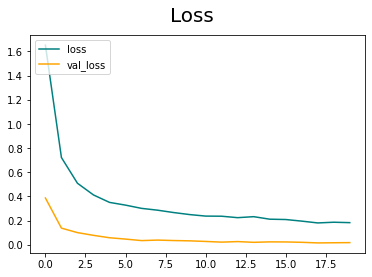

In [55]:
# LOSS
fig = plt.figure()
plt.plot(hist.history['loss'],color= 'teal',label = 'loss')
plt.plot(hist.history['val_loss'],color = 'orange',label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

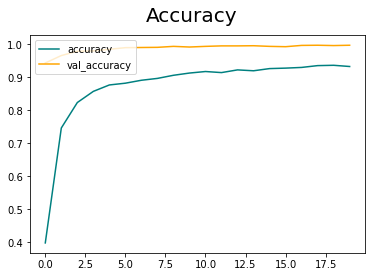

In [56]:
# ACCURACY
fig = plt.figure()
plt.plot(hist.history['accuracy'],color = 'teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'orange',label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

**EVALUATING MODEL ON TEST SET**

In [57]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [58]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [59]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9940239191055298, Recall:0.9900793433189392, Accuracy:0.9920634627342224


**SAVING MODEL**

In [60]:
model.save(os.path.join('Model','OCR.h5'))